In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from model import KeywordSpottingModel
from data_loader import load_speech_commands_dataset, TFDatasetAdapter, load_bg_noise_dataset
from utils import set_memory_GB,print_model_size, log_to_file
from augmentations import add_time_shift_and_align, add_silence
from train import trainig_loop





/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [2]:
torch.cuda.is_available()

True

In [3]:
set_memory_GB(1)

Memory fraction set to 0.022458079576498518
Memory fraction in GB: 1.0


In [4]:
train_ds, val_ds, test_ds, silence_ds , info = load_speech_commands_dataset()
bg_noise_ds = load_bg_noise_dataset()

2024-09-10 08:53:29.373758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 08:53:29.381192: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 08:53:29.395691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 08:53:29.424702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 08:53:29.432451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attemptin

In [5]:
# maintain seed for repructablity
np.seed = 42
# tf.random.set_seed(42)
torch.manual_seed(0)

In [6]:
label_names = info.features['label'].names
print(label_names)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [7]:
augmentations = [
    lambda x: add_time_shift_and_align(x),
]

In [20]:
# Convert the TFDS dataset to a PyTorch Dataset
fixed_length = 16000
n_mfcc = 13
n_fft = 640
hop_length = 320
n_mels = 40
pytorch_train_dataset = TFDatasetAdapter(train_ds, bg_noise_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentation = augmentations,noise_level=0.5)
pytorch_val_dataset = TFDatasetAdapter(val_ds, None, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentation=None)

2024-09-10 09:27:36.646584: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
# #play sound from dataset
# import IPython.display as ipd

# for i in range(10):
#     x, y = pytorch_train_dataset[i]
#     print(label_names[y])
#     ipd.display(ipd.Audio(x.numpy(), rate=16000))
#     # print(x.shape)

In [22]:
# Create a DataLoader to feed the data into the model
batch_size = 32
train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size, shuffle=True,num_workers=4,prefetch_factor=2)
val_loader = DataLoader(pytorch_val_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

In [23]:
import torch.nn as nn
from mamba_ssm import Mamba

# Define model architecture
class KeywordSpottingModel_with_cls(nn.Module):
    def __init__(self, input_dim, d_model, d_state, d_conv, expand, label_names, num_mamba_layers=1):
        super(KeywordSpottingModel_with_cls, self).__init__()
        self.proj = nn.Linear(input_dim, d_model)  # Initial projection layer
        
        # CLS token: learnable parameter with shape [1, 1, d_model]
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))

        # Stack multiple Mamba layers with RSMNorm layer
        self.mamba_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()

        for _ in range(num_mamba_layers):
            self.mamba_layers.append(Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand))
            self.layer_norms.append(nn.modules.normalization.RMSNorm(d_model))

        self.fc = nn.Linear(d_model, len(label_names))  # Output layer
        self.dropout = nn.Dropout(0.2)  # Dropout layer with a dropout rate of 0.5

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, num_frames, num_mfcc]
        x = self.proj(x)  # Project input to d_model dimension
        
        # Create a CLS token and expand it across the batch dimension
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: [batch_size, 1, d_model]
        
        # Append the CLS token to the input sequence
        x = torch.cat((x, cls_tokens), dim=1)  # Shape: [batch_size, num_frames + 1, d_model]

        x = x.permute(0, 2, 1)  # Transpose to [batch_size, d_model, num_frames + 1] for Mamba
        
        for mamba_layer, layer_norm in zip(self.mamba_layers, self.layer_norms):
            x = mamba_layer(x)
            x = layer_norm(x)  # Apply RMSNorm after Mamba layer
        
        x = self.dropout(x)  # Apply dropout after Mamba layers
        
        # Extract the CLS token output (last token)
        cls_output = x[:, :, -1]  # Shape: [batch_size, d_model]
        
        x = self.fc(cls_output)
        return x

# Training loop

# With L2 regulariztion AND Droput layer

In [24]:
# Initialize model, loss function, and optimizer
input_dim = 39  # Number of MFCC features
d_model = 52  # Number of frames + 1 for CLS token
d_state = 16
d_conv = 4
expand = 2

model = KeywordSpottingModel_with_cls(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, label_names=label_names, num_mamba_layers=1).to("cuda")

# class_weights = class_weights / np.sum(class_weights)  # Normalize class weights
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda")  # Convert to tensor
criterion = nn.CrossEntropyLoss().to("cuda")  # Loss function with class weights
base_optimizer = optim.Adam(model.parameters(), lr=0.0024, weight_decay=2.80475e-05) # weight_decay for L2 regulariztopn

from torch_optimizer import Lookahead

optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # Wrap around Adam


In [25]:
import torch.optim as optim
# Adding learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [26]:



# Training loop
num_epochs = 100

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

train_accuracies, val_accuracies, train_losses, val_losses = trainig_loop(model, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler)





100%|████████████████████████████████████████████████████████████████████| 962/962 [00:36<00:00, 26.72it/s]

Epoch 1/100, Training Loss: 1.5869365121371533, Training Accuracy: 43.68682765120738%


Validation Loss: 0.7578996383938296, Validation Accuracy: 74.18309478800973%
Learning rate after epoch 1: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:31<00:00, 30.96it/s]

Epoch 2/100, Training Loss: 0.9572202281681763, Training Accuracy: 67.61025707692808%


Validation Loss: 0.6066649222168429, Validation Accuracy: 80.17823386443425%
Learning rate after epoch 2: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:31<00:00, 30.46it/s]

Epoch 3/100, Training Loss: 0.8016237558142559, Training Accuracy: 72.38454288407164%


Validation Loss: 0.49799152951816034, Validation Accuracy: 83.60788549824467%
Learning rate after epoch 3: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:31<00:00, 30.76it/s]

Epoch 4/100, Training Loss: 0.7427051228136134, Training Accuracy: 74.56855926419448%


Validation Loss: 0.5075606022929323, Validation Accuracy: 83.2028085336214%
Learning rate after epoch 4: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:30<00:00, 31.78it/s]

Epoch 5/100, Training Loss: 0.6908436579447774, Training Accuracy: 76.50882381617862%


Validation Loss: 0.45650086487675534, Validation Accuracy: 85.5522549284364%
Learning rate after epoch 5: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:31<00:00, 30.58it/s]

Epoch 6/100, Training Loss: 0.6531613477023624, Training Accuracy: 77.76658324937436%


Validation Loss: 0.43079154553084537, Validation Accuracy: 85.79530110721036%
Learning rate after epoch 6: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:30<00:00, 31.64it/s]

Epoch 7/100, Training Loss: 0.6253084604494785, Training Accuracy: 78.77084078130586%


Validation Loss: 0.3888941339120783, Validation Accuracy: 87.25357817985417%
Learning rate after epoch 7: [0.0024]
Best model saved


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:31<00:00, 30.59it/s]

Epoch 8/100, Training Loss: 0.6047574029828803, Training Accuracy: 79.1413435600767%


Validation Loss: 0.3827903365780567, Validation Accuracy: 87.84769106130165%
Learning rate after epoch 8: [0.0024]
Best model saved


 27%|██████████████████▌                                                 | 262/962 [00:08<00:20, 34.40it/s]

In [21]:
# load test data
pytorch_test_dataset = TFDatasetAdapter(test_ds,None, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentation=None)
test_loader = DataLoader(pytorch_test_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

# Evaluate the model on the test set
accuracy = 0
total = 0
model.eval()

with torch.no_grad():
    for audio, labels in test_loader:
        audio, labels = audio.to("cuda"), labels.to("cuda")
        outputs = model(audio)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
test_accuracy = 100 * accuracy / total
print(f'Test Accuracy: {test_accuracy}%')





2024-09-05 09:08:18.405315: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test Accuracy: 93.22533136966126%


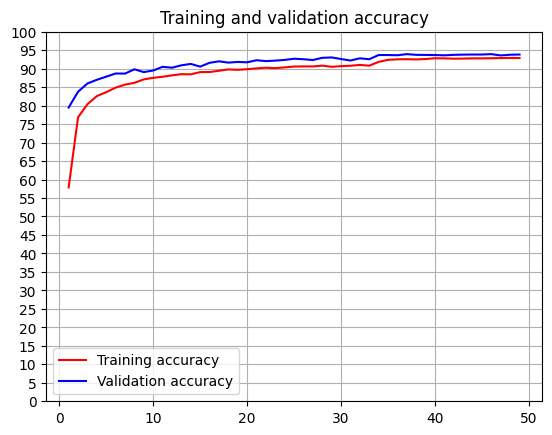

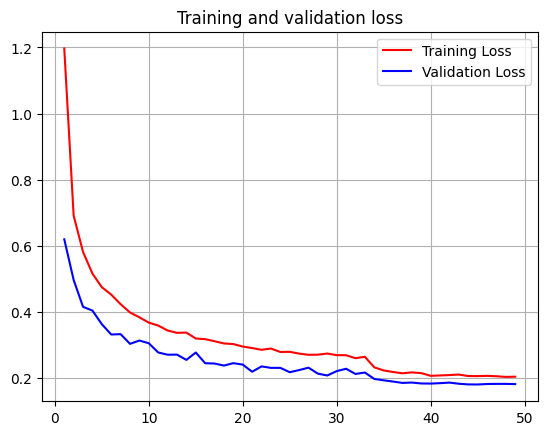

In [22]:
from utils import plot_learning_curves

plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses)

In [23]:
import pandas as pd
from utils import compute_inference_GPU_mem
#save model size(macs, params) and accuracy
macs, params = print_model_size(model,input_size=torch.randn(batch_size, input_dim, d_model-1).to("cuda"))
macs = macs/1e9
accuracy = test_accuracy
data = {'Model': ['KeywordSpottingModel_RSM_Norm_0-1-2_order_cls_bgnoise'], 'GMACs': [macs], 'Params': [params], 'Accuracy': [accuracy]}
model_config = {'input_dim': input_dim, 'd_model': d_model, 'd_state': d_state, 'd_conv': d_conv, 'expand': expand}
data.update(model_config)
inf_GPU_mem = compute_inference_GPU_mem(model, input=torch.randn(1, input_dim, d_model-1).to("cuda"))
#inference macs and params
inf_macs, inf_params = print_model_size(model,input_size=torch.randn(1, input_dim, d_model-1).to("cuda"))
inference_data = {'Inference CUDA Mem in MB': [inf_GPU_mem], 'Inference GMACs': [inf_macs/1e9], 'Inference Params': [inf_params]}
data.update(inference_data)
df = pd.DataFrame(data, index=[0])
df.to_csv('results.csv', mode='a', header=False)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.

MACs: 153694008.0 Which are 0.153694008 Giga-MACs, Params: 41716.0

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.

MACs: 5620524.0 Which are 0.005620524 Giga-MACs, Params: 41716.0



In [ ]:
with torch.profiler.profile(with_flops=True) as prof:
    model(torch.randn(32, input_dim, d_model-1).to("cuda"))

# Print FLOPs
print(prof.key_averages().table(sort_by="flops"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total KFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               aten::mm         4.65%     342.751us         6.26%     461.124us      92.225us      30.080us        20.37%      30.080us       6.016us             5     74457.344  
                                              aten::mul         0.91%      66.738us         1.22%      89.993us      44.996us       6.048us         4.1